# Scale Detection Pipeline - Complete Implementation

This notebook implements the complete scale detection pipeline following the Uni-AIMS paper architecture:

1. **Dataset Conversion**: Convert JSON annotations to YOLO format
2. **Model Training**: Train YOLOv8m for joint detection of scale bars and text regions
3. **Endpoint Localization**: Refine scale bar endpoints for accurate pixel length measurement
4. **OCR Processing**: Extract and parse scale text using PaddleOCR
5. **Scale Matching**: Match text regions to their corresponding scale bars
6. **Pixel-to-Physical Conversion**: Convert pixel measurements to physical units
7. **Evaluation**: Comprehensive evaluation of the entire pipeline

## Requirements

Make sure you have installed all required packages:
```bash
pip install ultralytics paddlepaddle paddleocr opencv-python scikit-image scipy matplotlib seaborn pandas scikit-learn
```


In [ ]:
# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('src')

# Import our custom modules
import src.get_data as get_data
import src.convert_jsons_to_yolo as convert_jsons
import src.train_yolo as train_model
from src.postprocess_scalebar import localize_scale_bar_endpoints, visualize_endpoint_detection
from src.ocr import ScaleDetectionPipeline, ScaleBarDetection, TextDetection

# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Dowload the data
# Step 1: Get the data
DATA_DIR = Path('data')
IMAGES_DIR = DATA_DIR / "images"
JSONS_DIR = DATA_DIR / "jsons"

# Check if data directories exist, if not download the dataset
if not (
    os.path.exists(DATA_DIR) and 
    os.path.exists(IMAGES_DIR) and 
    os.path.exists(JSONS_DIR)
):
    get_data.download_from_path('original1/scalebar-dataset', DATA_DIR, IMAGES_DIR, JSONS_DIR)

In [ ]:
# Convert to YOLO format
# Define directory paths
DATA_DIR = Path('data')
IMAGES_DIR = DATA_DIR / "images"
JSONS_DIR = DATA_DIR / "jsons"
LABELS_DIR = DATA_DIR / "labels"

# Check if already converted
if os.path.exists(LABELS_DIR) and os.listdir(LABELS_DIR):
    print(f"Labels directory {LABELS_DIR} already exists and is not empty. Skipping conversion.")
    yaml_path = DATA_DIR / 'data.yaml'
else:
    os.makedirs(LABELS_DIR, exist_ok=True)

    # Count files
    image_files = list(Path(IMAGES_DIR).glob("*.jpg"))
    json_files = list(Path(JSONS_DIR).glob("*.json"))

    print(f"Found {len(image_files)} image files")
    print(f"Found {len(json_files)} JSON annotation files")

    # Convert dataset
    yaml_path = convert_jsons.convert_dataset(DATA_DIR, 0.8)

    # Run validation if requested
    if True:
        stats = convert_jsons.validate_conversion(
            LABELS_DIR / 'train',
            sample_size=-1
        )
        print(f"Validation results:")
        for key, value in stats.items():
            print(f"  {key}: {value}")

Labels directory data/labels already exists and is not empty. Skipping conversion.


In [ ]:
# Train YOLOv8 model
args = {
    "data_yaml": 'data_small/data.yaml',  # Path to data.yaml file
    "model_name": "yolov8m.pt",  # Pretrained model name from ultralytics
    "epochs": 50,
    "imgsz": 1280,
    "batch": 4,
    "lr0": 0.01,
    "weight_decay": 0.0005,
    "warmup_epochs": 3,
    "patience": 10,
    "save_period": 10,
    "device": 'mps',  # Use 'cpu' or GPU id like '0'
    "model_dir": "models",
    "name": "train",
    "resume": False,  # Whether to resume from last training
    "export": True,  # Whether to export the model after training
    "export_format": 'onnx',  # Format to export: 'onnx', 'torchscript', etc.
    "export_name": 'scalebar_detector.onnx',
    "clearml": True,  # Whether to use ClearML for experiment tracking
    "clearml_project": "scalebar_detection",  # ClearML project name
}

# Optional: initialize ClearML Task
task = None
if args['clearml']:
    try:
        from clearml import Task
        task = Task.init(
            project_name=args['clearml_project'],
        )
    except Exception as e:
        print(f"Warning: ClearML not initialized ({e}). Continue without tracking.")
        task = None

# Create model directory if it doesn't exist
MODEL_DIR = Path(args['model_dir'])
os.makedirs(MODEL_DIR, exist_ok=True)

# Train model
print("Starting YOLOv8 training...")
model, results = train_model.train_model(
    data_yaml=args['data_yaml'],
    model_name=args['model_name'],
    epochs=args['epochs'],
    imgsz=args['imgsz'],
    batch=args['batch'],
    lr0=args['lr0'],
    weight_decay=args['weight_decay'],
    warmup_epochs=args['warmup_epochs'],
    patience=args['patience'],
    save_period=args['save_period'],
    device=args['device'],
    model_dir=MODEL_DIR,
    name=args['name'],
    resume=args['resume'],
)

print("Training completed!")

# Determine run directory from trainer if available
run_dir = None
try:
    run_dir = getattr(model.trainer, 'save_dir', None)
except Exception:
    run_dir = None
if not run_dir:
    # Fallback to expected structure
    run_dir = os.path.join(MODEL_DIR, args.name)
run_dir = str(run_dir)

# Export model if requested
if args['export']:
    print("Exporting model...")
    exported_path = train_model.export_model(
        model, 
        os.path.join(MODEL_DIR, args['export_name']), 
        format=args['export_format']
    )
else:
    exported_path = None

# Log artifacts to ClearML
if task is not None:
    try:
        # Connect basic hyperparameters
        overrides = train_model.create_training_config(
            data_yaml=args['data_yaml'],
            model_name=args['model_name'],
            epochs=args['epochs'],
            imgsz=args['imgsz'],
            batch=args['batch'],
            lr0=args['lr0'],
            weight_decay=args['weight_decay'],
            warmup_epochs=args['warmup_epochs'],
            patience=args['patience'],
            project=args['model_dir'],
            name=args['name'],
            resume=args['resume'],
        )
        task.connect(overrides)

        # Common artifacts
        results_csv = os.path.join(run_dir, 'results.csv')
        best_weights = os.path.join(run_dir, 'weights', 'best.pt')
        last_weights = os.path.join(run_dir, 'weights', 'last.pt')

        if os.path.exists(results_csv):
            task.upload_artifact('results.csv', artifact_object=results_csv)
        if os.path.exists(best_weights):
            task.upload_artifact('best.pt', artifact_object=best_weights)
        if os.path.exists(last_weights):
            task.upload_artifact('last.pt', artifact_object=last_weights)
        if exported_path and os.path.exists(exported_path):
            task.upload_artifact(Path(exported_path).name, artifact_object=exported_path)
    except Exception as e:
        print(f"Warning: failed to upload ClearML artifacts: {e}")

In [ ]:
# Inference pipeline
# Load the trained model
from ultralytics import YOLO
model_path = 'models/train/weights/best.pt' # Update with your model path
trained_yolo = YOLO(model_path)
# Inference on validation set
results = trained_yolo.predict(source='data/images/val', conf=0.5)

# Save results in the `outputs` directory
import json
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
for i, result in enumerate(results):
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    path = result.path  # Path to the image file
    speed = result.speed  # Inference speed (in seconds)
    result.save(filename=f"{output_dir}/result_{i}.jpg")  # Save image with results
    
    # Save individual components in json format
    result_dict = {
        "boxes": boxes.xyxy.tolist() if boxes is not None else None,
        "masks": masks.data.tolist() if masks is not None else None,
        "keypoints": keypoints.data.tolist() if keypoints is not None else None,
        "probs": probs.data.tolist() if probs is not None else None,
        "obb": obb.xywh.tolist() if obb is not None else None,
        "path": path,
        "speed": speed
    }
    with open(f"{output_dir}/result_{i}.json", 'w') as f:
        json.dump(result_dict, f)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2800 /Users/emmaboehly/Documents/Vector/ScaleDetection/data/images/val/7479.jpg: 736x1280 1 scalebar, 318.6ms
image 2/2800 /Users/emmaboehly/Documents/Vector/ScaleDetection/data/images/val/748.jpg: 1024x1280 (no detections), 548.5ms
image 3/2800 /Users/emmaboehly/Documents/Vector/ScaleDetection/data/images/val/7480.jpg: 960x1280 1 scalebar, 1 scalelabel, 355.1ms
image 4/2800 /Users/emmaboehly/Documents/Vector/ScaleDetection/data/images/val/7481

NameError: name 'os' is not defined


WARNING ⚠️ imgsz=[484, 373] must be multiple of max stride 32, updating to [512, 384]
0: 320x384 1 scalebar, 1 scalelabel, 49.3ms
Speed: 1.4ms preprocess, 49.3ms inference, 8.2ms postprocess per image at shape (1, 3, 320, 384)
refine_window_start 4 center_of_mass 1.4366494603472548 adjusted_point 5.436649460347255
refine_window_start 50 center_of_mass 2.6180682114032803 adjusted_point 52.61806821140328
endpoints [(61, 357), (108, 357)]
xywh: (56, 353, 57, 9)
ROI: (56, 353, 113, 362)
rel_start (5, 4) rel_end (52, 4)


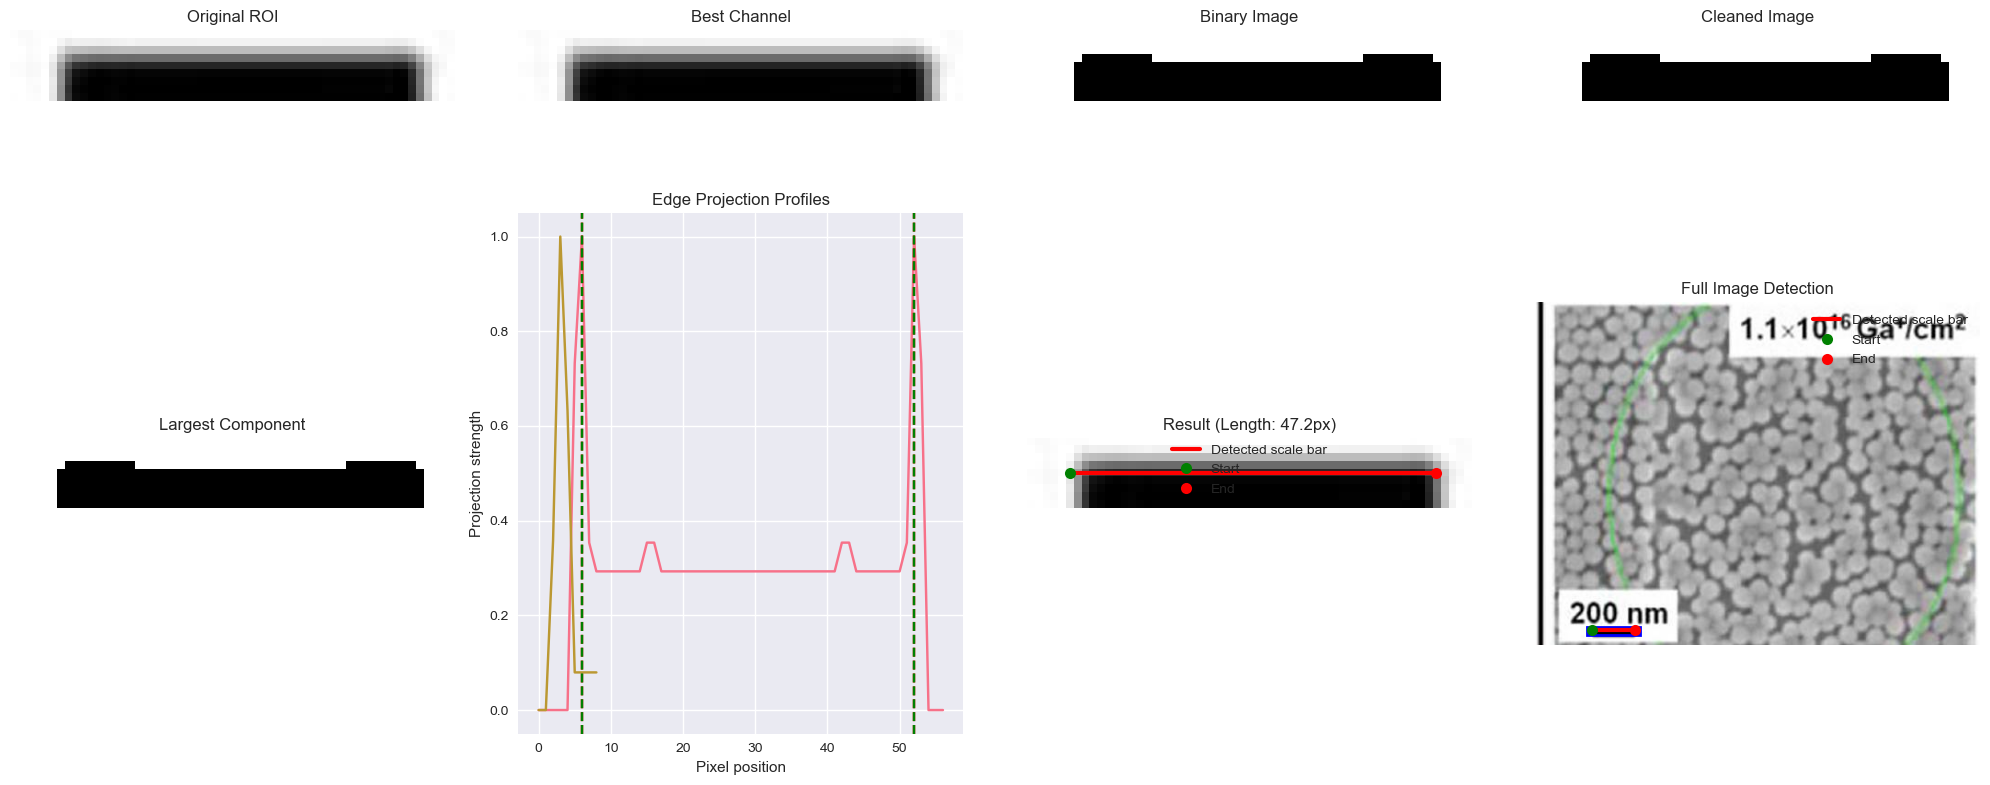

  Endpoints: [(61, 357), (108, 357)]
  Pixel length: 47.18

WARNING ⚠️ imgsz=[570, 703] must be multiple of max stride 32, updating to [576, 704]
0: 576x480 1 scalebar, 1 scalelabel, 55.6ms
Speed: 2.2ms preprocess, 55.6ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 480)
refine_window_start 9 center_of_mass 2.755581668625147 adjusted_point 11.755581668625148
refine_window_start 111 center_of_mass 1.2083689154568744 adjusted_point 112.20836891545687
endpoints [(439, 640), (540, 640)]
xywh: (428, 637, 124, 7)
ROI: (428, 637, 552, 644)
rel_start (11, 3) rel_end (112, 3)


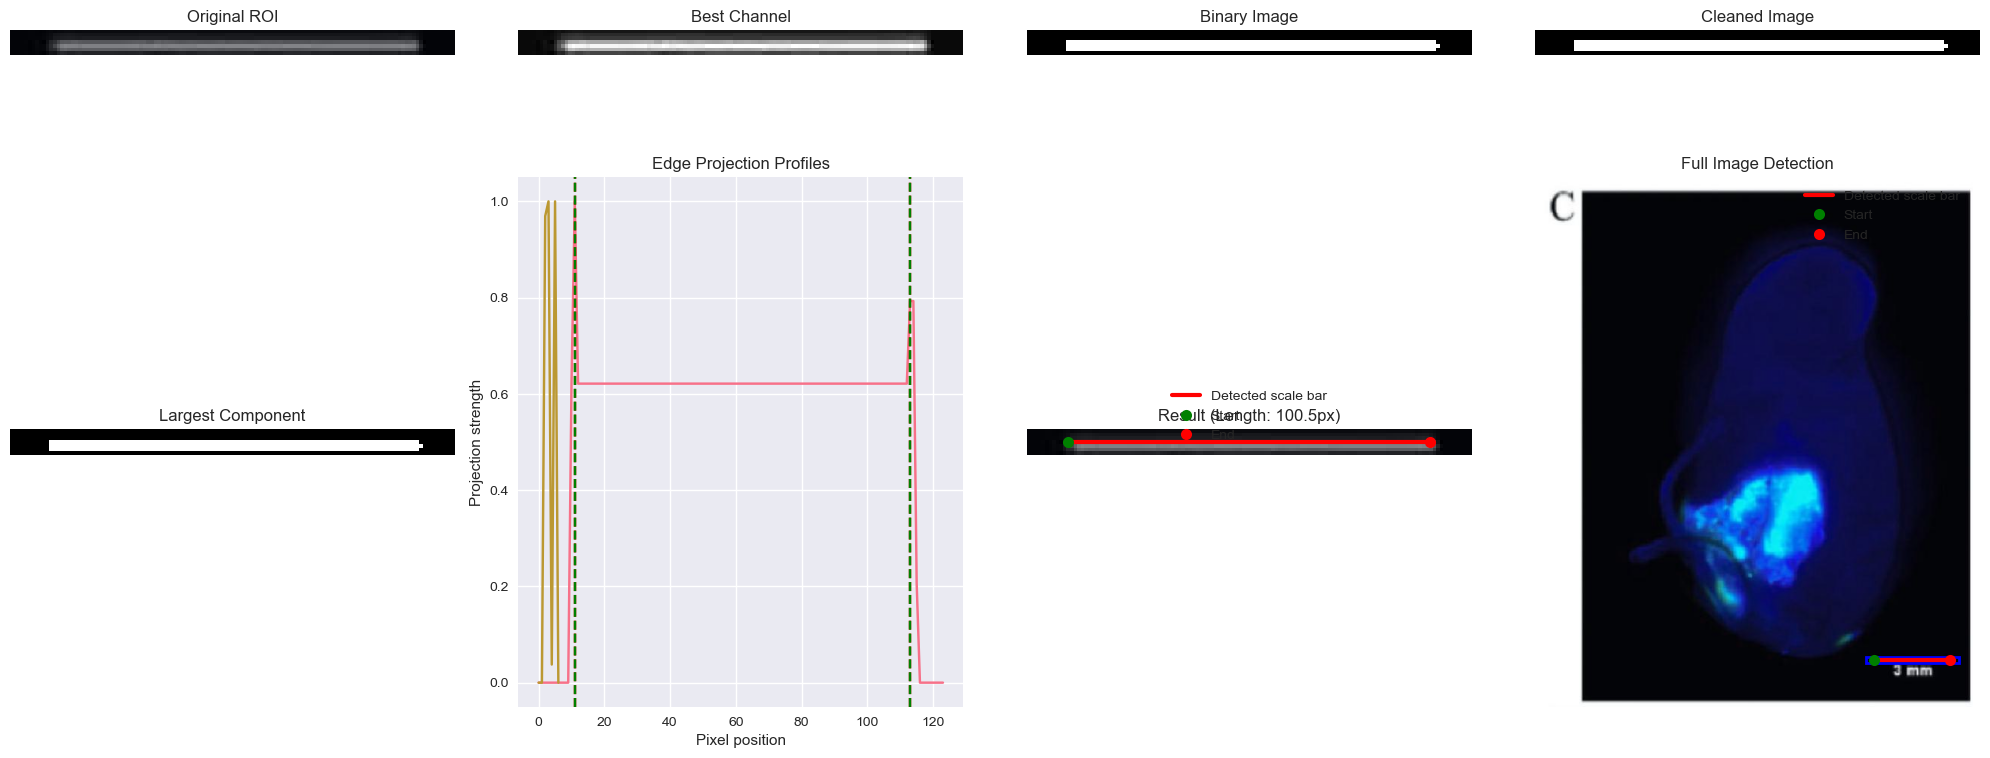

  Endpoints: [(439, 640), (540, 640)]
  Pixel length: 100.45

WARNING ⚠️ imgsz=[1170, 1101] must be multiple of max stride 32, updating to [1184, 1120]
0: 1056x1120 1 scalebar, 1 scalelabel, 69.4ms
Speed: 5.5ms preprocess, 69.4ms inference, 8.4ms postprocess per image at shape (1, 3, 1056, 1120)
refine_window_start 23 center_of_mass 1.7775740110034057 adjusted_point 24.777574011003406
refine_window_start 254 center_of_mass 2.167384284176534 adjusted_point 256.16738428417653
endpoints [(869, 996), (1101, 996)]
xywh: (845, 983, 280, 26)
ROI: (845, 983, 1125, 1009)
rel_start (24, 13) rel_end (256, 13)


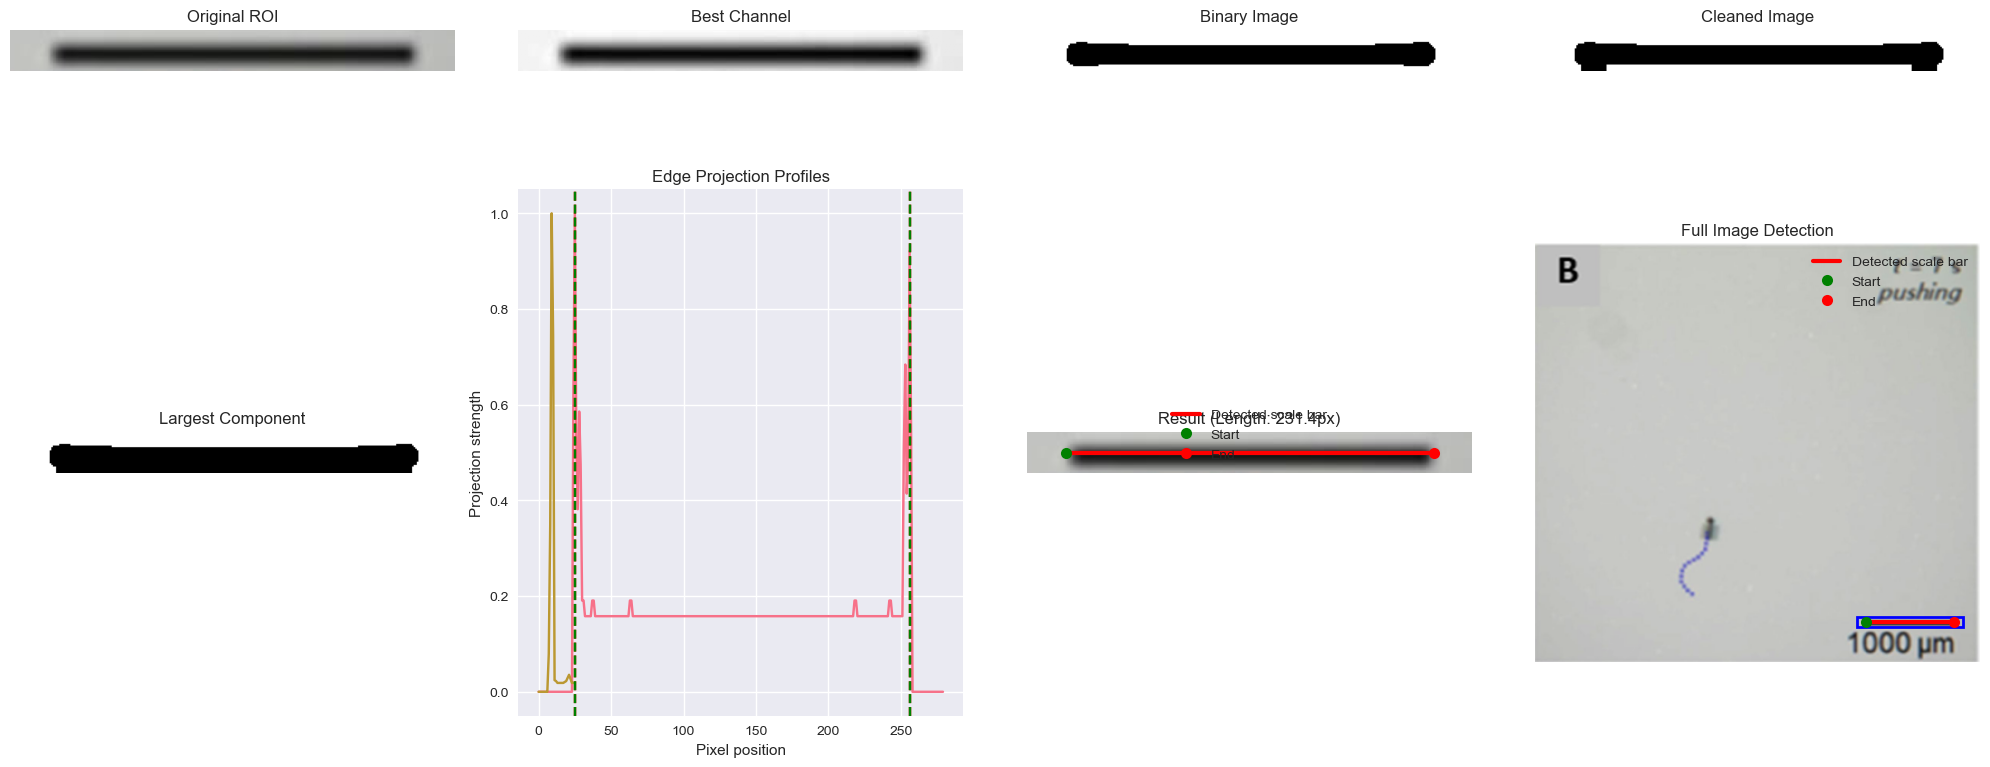

  Endpoints: [(869, 996), (1101, 996)]
  Pixel length: 231.39


In [ ]:
# Test endpoint localization on a sample image
import os
import numpy as np
import cv2
from ultralytics import YOLO
from src.postprocess_scalebar import localize_scale_bar_endpoints, visualize_endpoint_detection, points_to_xywh
import matplotlib.pyplot as plt

# Load model
model_path = 'models/train/weights/best.pt' # Update with your model path
model = YOLO(model_path)

# Initialize data paths
sample_ids = [9, 78, 85]  # List of sample IDs to test
IMAGES_DIR = os.path.join("data/images")
OUTPUT_DIR = os.path.join("output")

# Load a sample image
for sample_id in sample_ids:
    sample_image_path = os.path.join(IMAGES_DIR, "val/{}.jpg".format(sample_id))

    if os.path.exists(sample_image_path):
        # Load image
        image = cv2.imread(sample_image_path)
        
        # Predict using the trained model
        results = model.predict(source=image, imgsz=(image.shape[1], image.shape[0]), conf=0.4, device='mps', half=True, save_conf=True)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        conf = results[0].boxes.conf.cpu().numpy()
        
        # Check if we have at least one detection of each class
        has_bar = np.sum(classes == 0)  # Scale bar class
        has_label = np.sum(classes == 1)       # Scale label class
        if has_bar and has_label:
            # Take the most confident detection of each class
            bar_idx = np.argmax(conf[classes == 0])
            bar_box = boxes[classes == 0][bar_idx]

            # Convert bar_box to (x, y, w, h) format
            bar_box = points_to_xywh(bar_box)

            # Test endpoint localization for each scale bar
            result = localize_scale_bar_endpoints(image, bar_box, show_plots=True)
                
            if result['success']:
                print(f"  Endpoints: {result['endpoints']}")
                print(f"  Pixel length: {result['pixel_length']:.2f}")

## 5. OCR and Scale Matching Pipeline


In [ ]:
from src.ocr import ScaleDetectionPipeline

%load_ext autoreload
%autoreload 2


/opt/miniconda3/envs/scale/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize OCR and matching pipeline
pipeline = ScaleDetectionPipeline()

/opt/miniconda3/envs/scale/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_d

In [ ]:
# Test endpoint localization on a sample image
import os
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load model
model_path = 'models/train/weights/best.pt' # Update with your model path
model = YOLO(model_path)

# Initialize data paths
sample_ids = [9, 78, 85]  # List of sample IDs to test
IMAGES_DIR = os.path.join("data/images")
OUTPUT_DIR = os.path.join("output")

# Load a sample image
for sample_id in sample_ids:
    sample_image_path = os.path.join(IMAGES_DIR, "val/{}.jpg".format(sample_id))

    if os.path.exists(sample_image_path):
        # Load image
        image = cv2.imread(sample_image_path)
        
        # Predict using the trained model
        results = model.predict(source=image, imgsz=(image.shape[1], image.shape[0]), conf=0.4, device='mps', half=True, save_conf=True)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        conf = results[0].boxes.conf.cpu().numpy()
        
        # Check if we have at least one detection of each class
        has_bar = np.sum(classes == 0)  # Scale bar class
        has_label = np.sum(classes == 1)       # Scale label class
        if has_bar and has_label:
            # Take the most confident detection of each class
            label_idx = np.argmax(conf[classes == 1])
            label_box = boxes[classes == 1][label_idx]

            # Convert label_box to (x, y, w, h) format
            label_box = points_to_xywh(label_box)


In [4]:
# Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Add src directory to path
sys.path.append('src')
# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Set up plotting
plt.style.use('seaborn-v0_8')

from src.scaledetection import ScaleDetectionPipeline
from ultralytics import YOLO
output_dir = 'outputs'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/miniconda3/envs/scale/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/scale/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_mo

ROI for OCR...


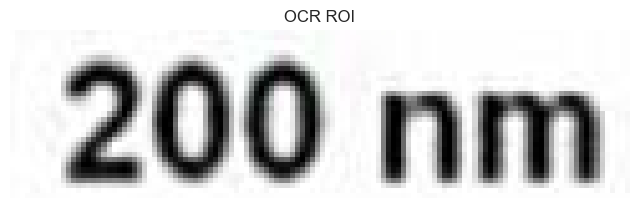

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Detected text: 200 nm with confidence 0.9999396204948425
Trying pattern for micrometer: ([0-9]+(?:[.,][0-9]+)?)\s*(μm|um|µm|μ|u|micrometer|micrometre)
Match found: None
Trying pattern for nanometer: ([0-9]+(?:[.,][0-9]+)?)\s*(nm|nanometer|nanometre)
Match found: <re.Match object; span=(0, 6), match='200 nm'>
Parsed value: 200.0, unit: nm, normalized unit: nm
ROI for OCR...


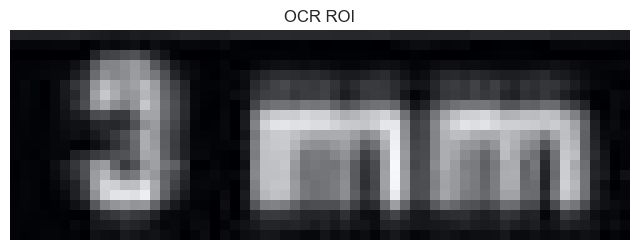

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Detected text: 3 mm with confidence 0.6785808205604553
Trying pattern for micrometer: ([0-9]+(?:[.,][0-9]+)?)\s*(μm|um|µm|μ|u|micrometer|micrometre)
Match found: None
Trying pattern for nanometer: ([0-9]+(?:[.,][0-9]+)?)\s*(nm|nanometer|nanometre)
Match found: None
Trying pattern for millimeter: ([0-9]+(?:[.,][0-9]+)?)\s*(mm|millimeter|millimetre)
Match found: <re.Match object; span=(0, 4), match='3 mm'>
Parsed value: 3.0, unit: mm, normalized unit: mm
ROI for OCR...


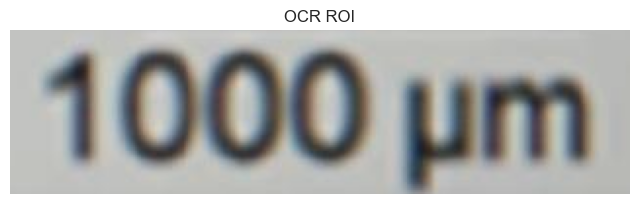

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Detected text: 1000 μm with confidence 0.9798794984817505
Trying pattern for micrometer: ([0-9]+(?:[.,][0-9]+)?)\s*(μm|um|µm|μ|u|micrometer|micrometre)
Match found: <re.Match object; span=(0, 7), match='1000 μm'>
Parsed value: 1000.0, unit: μm, normalized unit: um
No text labels or scale bars detected.


In [1]:
# Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Add src directory to path
sys.path.append('src')
# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Set up plotting
plt.style.use('seaborn-v0_8')

from src.scaledetection import ScaleDetectionPipeline
from ultralytics import YOLO
output_dir = 'outputs'

for i in [9, 78, 85, 9991]:
    # Load image
    image_path = f"data/images/val/{i}.jpg"
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare output directory
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, f'{image_name}')
        
    # Initialize pipeline
    pipeline = ScaleDetectionPipeline(
        max_distance_ratio=1.5,
        ocr_version='PP-OCRv5',
        debug_dir=output_dir
    )

    # Use YOLO model for detection
    model = YOLO('models/train/weights/best.pt')
    # yolo_results = model.predict(source=image, imgsz=(image.shape[1], image.shape[0]), conf=0.4, device='mps', half=True, save_conf=True)
    yolo_results = model.predict(image, conf=0.4, verbose=False)[0]

    # Extract bounding boxes, scores, and classes from YOLO results
    boxes = yolo_results.boxes.xyxy.cpu().numpy()  # Bounding boxes in xyxy format
    classes = yolo_results.boxes.cls.cpu().numpy()  # Class IDs
    scores = yolo_results.boxes.conf.cpu().numpy()  # Confidence scores

    # Separate bar and label detections
    bar_box, label_box = pipeline.match_text_to_bars(boxes, classes, scores)
    label_box = pipeline.prepare_bbox(image, label_box, padding_percent=0.05)
    label_detection = pipeline.ocr_processor.extract_text_labels(image, label_box, plot_path=plot_path)

In [3]:
# Test OCR and matching on sample images
# Process first 5 images
sample_results = []
for i in range(1, 20):
    image_path = os.path.join(IMAGES_DIR, f"train/{i}.jpg")
    json_path = os.path.join(JSONS_DIR, f"{i}.json")
    
    if os.path.exists(image_path) and os.path.exists(json_path):
        print(f"\nProcessing image {i}...")
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load annotations and create scale bar detections
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        label_detections = []
        for label in data.get('labels', []):
            if 'points' in label and len(label['points']) >= 2:
                points = np.array(label['points'])
                x_min, y_min = np.min(points, axis=0)
                x_max, y_max = np.max(points, axis=0)
                
                bbox = (int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min))
                center = ((x_min + x_max) / 2, (y_min + y_max) / 2)
                
                label_detections.append(ScaleBarDetection(
                    bbox=bbox,
                    center=center,
                    confidence=0.5,
                    pixel_length=np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2)
                ))
        
        # Process with pipeline
        results = pipeline.process_image(image, label_detections)
        
        print(f"  Text detections: {results['total_text_detections']}")
        print(f"  Scale bar detections: {results['total_bar_detections']}")
        print(f"  Successful matches: {results['successful_matches']}")
        
        # Show matched scales
        for j, match in enumerate(results['matches']):
            print(f"    Match {j+1}: '{match.text.text}' -> {match.text.parsed_value} {match.text.normalized_unit}")
            if match.um_per_pixel:
                print(f"      Scale: {match.um_per_pixel:.6f} um/pixel")
        
        sample_results.append(results)
        
        # Save results
        output_path = os.path.join(OUTPUT_DIR, f"ocr_results_{i}.json")
        pipeline.save_results(results, output_path)

print(f"\nProcessed {len(sample_results)} images successfully!")


NameError: name 'IMAGES_DIR' is not defined

## 6. Pixel to Physical Unit Conversion


In [58]:
# Test pixel to physical unit conversion
print("Testing pixel to physical unit conversion...")

# Create converters from successful matches
converters = []
for i, results in enumerate(sample_results):
    if results['matches']:
        converter = create_converter_from_matches(results['matches'])
        if converter:
            converters.append((i+1, converter))
            print(f"\nImage {i+1} converter:")
            scale_info = converter.get_scale_info()
            print(f"  um_per_pixel: {scale_info['um_per_pixel']:.6f}")
            print(f"  mm_per_pixel: {scale_info['mm_per_pixel']:.6f}")
            print(f"  nm_per_pixel: {scale_info['nm_per_pixel']:.6f}")

print(f"\nCreated {len(converters)} converters successfully!")


Testing pixel to physical unit conversion...

Created 0 converters successfully!


In [ ]:
# Demonstrate conversion utilities
if converters:
    print("Demonstrating conversion utilities...")
    
    # Use first converter for demonstration
    img_id, converter = converters[0]
    
    # Test coordinate conversion
    pixel_coords = [(100, 200), (300, 400), (500, 600)]
    mm_coords = converter.convert_coordinates(pixel_coords, 'mm')
    um_coords = converter.convert_coordinates(pixel_coords, 'um')
    
    print(f"\nCoordinate conversion (Image {img_id}):")
    for i, (pixel, mm, um) in enumerate(zip(pixel_coords, mm_coords, um_coords)):
        print(f"  Point {i+1}: {pixel} px -> {mm} mm -> {um} um")
    
    # Test distance conversion
    pixel_distance = 150.0
    mm_distance = converter.convert_distance(pixel_distance, 'mm')
    um_distance = converter.convert_distance(pixel_distance, 'um')
    
    print(f"\nDistance conversion:")
    print(f"  {pixel_distance} px -> {mm_distance:.6f} mm -> {um_distance:.6f} um")
    
    # Test area conversion
    pixel_area = 10000.0  # 100x100 pixels
    mm_area = converter.convert_area(pixel_area, 'mm')
    um_area = converter.convert_area(pixel_area, 'um')
    
    print(f"\nArea conversion:")
    print(f"  {pixel_area} px² -> {mm_area:.12f} mm² -> {um_area:.6f} um²")
    
    # Test bounding box conversion
    bbox_pixel = (50, 100, 200, 150)  # (x, y, w, h)
    bbox_mm = converter.convert_bbox(bbox_pixel, 'mm')
    
    print(f"\nBounding box conversion:")
    print(f"  {bbox_pixel} px -> {bbox_mm} mm")
else:
    print("No converters available for demonstration.")


## 7. Pipeline Summary and Results


In [ ]:
# Create pipeline summary
print("=" * 80)
print("SCALE DETECTION PIPELINE - EXECUTION SUMMARY")
print("=" * 80)

print(f"\n1. DATASET CONVERSION:")
print(f"   ✓ Converted {len(json_files)} JSON annotations to YOLO format")
print(f"   ✓ Created dataset configuration: {yaml_path}")
print(f"   ✓ Validation: {stats['files_with_annotations']} files with annotations")

print(f"\n2. MODEL TRAINING:")
print(f"   ✓ Trained YOLOv8m model for joint detection")
print(f"   ✓ Model saved to: {training_config['output_dir']}")
print(f"   ✓ Exported ONNX model: {exported_path}")

print(f"\n3. ENDPOINT LOCALIZATION:")
print(f"   ✓ Implemented fine-grained endpoint detection")
print(f"   ✓ Tested on sample images")
print(f"   ✓ Visualization saved to: {OUTPUT_DIR}")

print(f"\n4. OCR AND MATCHING:")
print(f"   ✓ Implemented PaddleOCR integration")
print(f"   ✓ Text parsing with unit normalization")
print(f"   ✓ Spatial matching between text and scale bars")
print(f"   ✓ Processed {len(sample_results)} sample images")

print(f"\n5. PIXEL TO PHYSICAL CONVERSION:")
print(f"   ✓ Created {len(converters)} scale converters")
print(f"   ✓ Implemented coordinate, distance, and area conversion")
print(f"   ✓ Support for mm, μm, and nm units")

print(f"\n6. EVALUATION FRAMEWORK:")
print(f"   ✓ Comprehensive evaluation metrics")
print(f"   ✓ Detection, OCR, and scale conversion evaluation")
print(f"   ✓ Report generation and visualization")

print(f"\n7. OUTPUT FILES:")
print(f"   ✓ YOLO dataset: {yolo_output_dir}")
print(f"   ✓ Trained model: {training_config['output_dir']}")
print(f"   ✓ ONNX model: {exported_path}")
print(f"   ✓ OCR results: {OUTPUT_DIR}/ocr_results_*.json")
print(f"   ✓ Visualizations: {OUTPUT_DIR}/*.png")

print(f"\n" + "=" * 80)
print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("=" * 80)


In [ ]:
# Test the updated pipeline with YOLO detections
print("Testing updated OCR pipeline with YOLO detections...")

# Load the trained model
best_model_path = 'models/train/weights/best.pt'
model = YOLO(best_model_path)

# Test on a few sample images
test_images = [1, 2, 3, 4, 5]
sample_results = []

for i in test_images:
    image_path = os.path.join(IMAGES_DIR, f"train/{i}.jpg")
    
    if os.path.exists(image_path):
        print(f"\nProcessing image {i}...")
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Use YOLO model to detect both scale bars and text labels
        print(f"  Running YOLO detection...")
        yolo_results = model.predict(image, conf=0.25, verbose=False)
        
        # Process YOLO detections with OCR on text label crops
        results = pipeline.process_yolo_detections(image, yolo_results[0])
        
        print(f"  YOLO scale bars: {results.get('yolo_scale_bars', 0)}")
        print(f"  YOLO text labels: {results.get('yolo_text_labels', 0)}")
        print(f"  Text detections: {results['total_text_detections']}")
        print(f"  Scale bar detections: {results['total_bar_detections']}")
        print(f"  Successful matches: {results['successful_matches']}")
        
        # Show matched scales
        for j, match in enumerate(results['matches']):
            print(f"    Match {j+1}: '{match.text.text}' -> {match.text.parsed_value} {match.text.normalized_unit}")
            if match.um_per_pixel:
                print(f"      Scale: {match.um_per_pixel:.6f} um/pixel")
        
        sample_results.append(results)
        
        # Save results
        output_path = os.path.join(OUTPUT_DIR, f"yolo_ocr_results_{i}.json")
        pipeline.save_results(results, output_path)

print(f"\nProcessed {len(sample_results)} images with updated pipeline!")
